## Introduction

Traffic sign recognition is a challenging, real-world problem relevant to AI-based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of classes (e.g. speed limit signs) that are very similar to each other. Further, the classifier has to be robust against large variations in visual appearances due to changes in illumination, partial occlusions, rotations, weather conditions, etc.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition. 

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with an interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

In [1]:
#@title Download the data
#!wget -qq https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
#!unzip -qq FullIJCNN2013.zip

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Loading and Feature Extraction

#### Get the features and labels of data

* Extract the features of the images within image sections only
* Extract labels of the images
* Resize the images to (30, 30) and convert to a numpy 1-D array

### Read the Labels

In [3]:
import pandas as pd

dfLabels = pd.read_csv('./FullIJCNN2013/gt.txt', sep = ";", header = None,
                       names = ['FileName',
                                'TopLeft',
                                'TopRight',
                                'BottomLeft',
                                'BottomRight',
                                'Label'])
print("Shape:", dfLabels.shape)
print(dfLabels.head())

Shape: (1213, 6)
    FileName  TopLeft  TopRight  BottomLeft  BottomRight  Label
0  00000.ppm      774       411         815          446     11
1  00001.ppm      983       388        1024          432     40
2  00001.ppm      386       494         442          552     38
3  00001.ppm      973       335        1031          390     13
4  00002.ppm      892       476        1006          592     39


### Read the images

In [4]:
import numpy as np
import os, glob
from PIL import Image
from tqdm import tqdm

RESIZE_X = 30
RESIZE_Y = 30
CHANNELS = 3

COLUMN_IDENTIFIER = 'id'
COLUMN_LABEL = 'Label'
COLUMN_FILENAME = 'FileName'
COLUMN_FILEPATH = 'FilePath'

def extractNeededPartsOfTheImage(filePath, 
                                 topLeft,
                                 topRight,
                                 bottomLeft,
                                 bottomRight):
  # Read the Image
  image = Image.open(filePath)

  # Crop the portion of the image which has a signal in it
  cropped = image.crop((topLeft, 
                        topRight,
                        bottomLeft, 
                        bottomRight))

  # Resize the image
  imageResized = cropped.resize((RESIZE_X, RESIZE_Y))

  return imageResized

def createImageDataFrame():
  # Declare a dataframe to hold all the data to use for modelling
  df = pd.DataFrame(columns = [COLUMN_FILEPATH, COLUMN_FILENAME, COLUMN_LABEL])
  for i in range(RESIZE_X * RESIZE_Y * CHANNELS):
    df[COLUMN_IDENTIFIER + str(i)] = None

  for filePath in tqdm(glob.glob('./FullIJCNN2013/*ppm')):
    # Get the coordinates for the file
    fileName = filePath.split("/")[-1]
    fileDetails = dfLabels.loc[dfLabels['FileName'] == fileName]

    # Extract all the sections of the image which has traffic signals
    for i in range(len(fileDetails)):
      imageResized = extractNeededPartsOfTheImage(filePath, 
                                                  fileDetails.TopLeft.tolist()[i], 
                                                  fileDetails.TopRight.tolist()[i],
                                                  fileDetails.BottomLeft.tolist()[i], 
                                                  fileDetails.BottomRight.tolist()[i]
                                                  )
      
      # Convert the image to a numpy array
      data = np.asarray(imageResized)

      # Flatten the image data to 1-D numpy array
      data1DArray = np.ndarray.flatten(data)

      # Store the image data in the dataframe
      dictTemp = {}
      for j in range(len(data1DArray)):
        dictTemp[COLUMN_IDENTIFIER + str(j)] = data1DArray[j]

      dictTemp[COLUMN_FILENAME] = fileName
      dictTemp[COLUMN_FILEPATH] = filePath
      dictTemp[COLUMN_LABEL] = fileDetails.Label.tolist()[i]
      dfTemp = pd.DataFrame([dictTemp])
      df = pd.concat([df, dfTemp]).reset_index(drop = True)

  return df

df = createImageDataFrame()
print("Shape:", df.shape)
print(df.head())
df.to_csv('./ImageData.csv', index = False)

100%|██████████| 900/900 [01:40<00:00,  8.99it/s]


Shape: (1213, 2703)
                    FilePath   FileName Label  id0 id1 id2  id3  id4  id5  \
0  ./FullIJCNN2013/00109.ppm  00109.ppm     3   41  37  31   30   28   23   
1  ./FullIJCNN2013/00135.ppm  00135.ppm     1   67  71  65  106  114  111   
2  ./FullIJCNN2013/00653.ppm  00653.ppm    35  117  70  70  116   68   67   
3  ./FullIJCNN2013/00653.ppm  00653.ppm    12   58  28  28   65   31   30   
4  ./FullIJCNN2013/00647.ppm  00647.ppm    38   48  44  49   45   45   48   

   id6  ... id2690 id2691 id2692 id2693 id2694 id2695 id2696 id2697 id2698  \
0   28  ...     27     31     31     26     30     31     27     30     31   
1  -92  ...    -23    -37    -31    -26    -39    -32    -29    -43    -32   
2  116  ...     76   -116     75     78   -114     77     78   -115     77   
3   72  ...     81   -109     78     79   -110     77     78   -108     79   
4   70  ...     37     44     42     38     42     41     37     40     40   

  id2699  
0     27  
1    -29  
2     77  
3   

### Data Exploration and Preprocessing

#### Show any one image

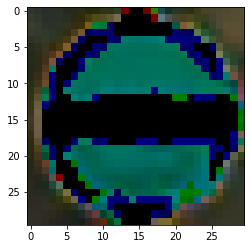

In [5]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
%matplotlib inline

dfTemp = df.drop([COLUMN_FILEPATH, COLUMN_FILENAME, COLUMN_LABEL], 
                 axis = 1, inplace = False)
columns = dfTemp.columns

def getImage(rowNumber):
  image1DArray = np.empty([RESIZE_X * RESIZE_Y * CHANNELS])

  for column in columns:
    columnNumber = int(column.replace(COLUMN_IDENTIFIER, ''))
    image1DArray[columnNumber] = int(dfTemp.iloc[rowNumber][column])

  imageArray = image1DArray.reshape(RESIZE_X, RESIZE_Y, CHANNELS)
  imageArray /= 255
  imageArray = np.clip(imageArray, 0, 1)

  return imageArray

imageToDisplay = getImage(701)
plt.imshow(imageToDisplay, interpolation = 'nearest')
plt.show()

#### Show any one image for each class

 54%|█████▍    | 657/1213 [00:03<00:02, 211.29it/s]


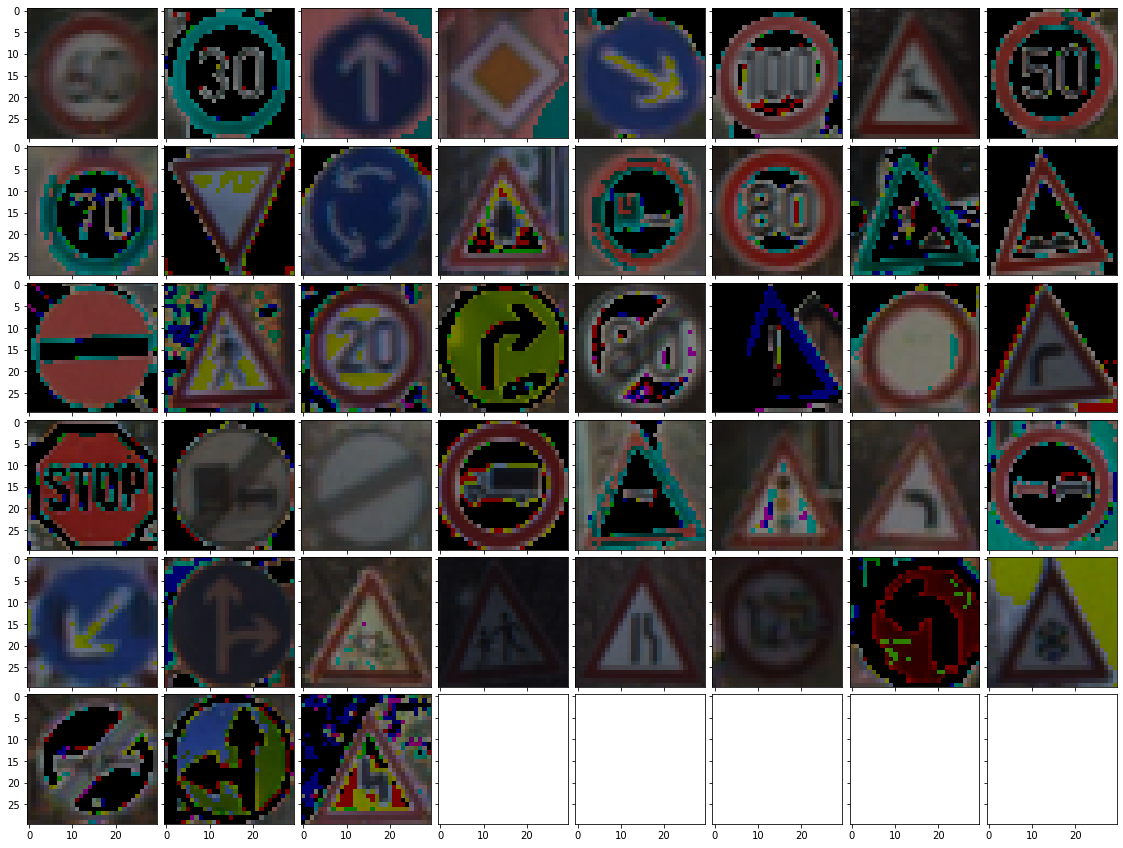

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
import math

NUM_COLUMNS = 8

# Get the unique Labels
uniqueLabels = df[COLUMN_LABEL].unique().tolist()

displayImageList = [None] * len(uniqueLabels)
imageTitleList = [None] * len(uniqueLabels)

fig = plt.figure(figsize=(20, 15))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(math.ceil(len(uniqueLabels) / NUM_COLUMNS), NUM_COLUMNS),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

imageNumber = 0
for i in tqdm(range(len(df))):
  labelForFile = df.loc[i][COLUMN_LABEL]
  if labelForFile in uniqueLabels:
    imageTitleList[imageNumber] = labelForFile
    displayImageList[imageNumber] = getImage(i)
    uniqueLabels.remove(labelForFile)
    imageNumber += 1

  if len(uniqueLabels) < 1:
    break

for ax, im in zip(grid, displayImageList):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

#### Plot the distribution of Classes

In [7]:
dfCounts = df[COLUMN_LABEL].value_counts().rename_axis(COLUMN_LABEL).reset_index(name='counts')
dfCounts

,Label,counts
0,38,88
1,12,85
2,13,83
3,2,81
4,10,80
5,1,79
6,4,68
7,8,57
8,5,53
9,7,41


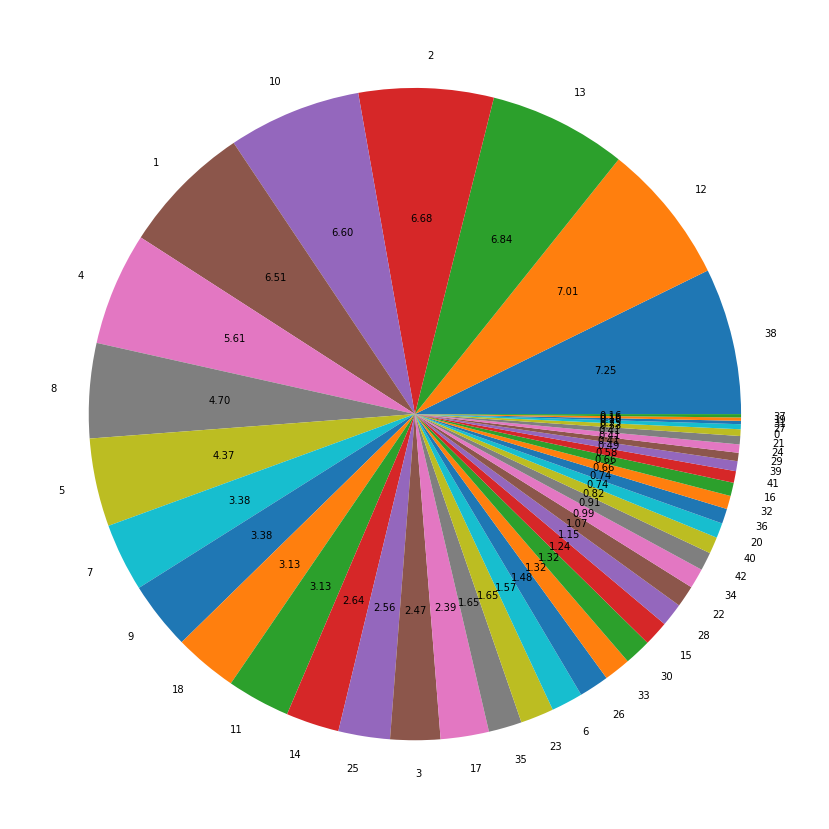

In [8]:
fig = plt.figure(figsize=(20, 15))
plt.pie(dfCounts.counts, labels = dfCounts.Label, autopct='%1.2f')
plt.show()

#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

In [9]:
from sklearn.preprocessing import normalize

X = normalize(dfTemp)
y = df[COLUMN_LABEL].astype('int')

### Train the AdaBoost classifier

* Split the data into train and test

* Train the AdaBoost classifier

* Get the accuracy score and performance metrics

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

model = AdaBoostClassifier()
model.fit(X_train, y_train)

yTrainPred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, yTrainPred))

yTestPred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, yTestPred))

Training Accuracy: 0.12061855670103093
Test Accuracy: 0.06584362139917696


### Train the Multi-Layer Perceptron classifier

In [12]:
from sklearn.neural_network import MLPClassifier

model1 = MLPClassifier(activation = 'relu', random_state = 42)
model1.fit(X_train, y_train)

yTrainPred = model1.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, yTrainPred))

yTestPred = model1.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, yTestPred))

Training Accuracy: 0.9855670103092784
Test Accuracy: 0.448559670781893
